<a href="https://colab.research.google.com/github/bcrompvoets/Star_Formation/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - PHYS 555 - Instructor: Seb Fabbro

## Breanna Crompvoets and Samuel Fielder

## Project Summary and Goals
Young Stellar Objects (YSOs) are newly forming stars which are yet to begin burning. They are split into different classes depending on their dust/gas envelope to protostar ratio, with Class 0 having the greatest envelope, and Class III no longer having an envelope. Due to the different ratios of envelope to protostar, each class appears differently in spectroscopy; thus the difference in fluxes between Spitzer IRAC bands are able to determine which class the data comes from. This project will focus on using the same data as Cornu and Montillaud (2021; CM21) to classify data points into three classes: Class I, Class II, and Contaminants. Only these three classes out of the original 7 available are chosen as Class 0 and I are very difficult to separate, and Class III is difficult to distinguish from regular stars. Furthermore, the contaminating classes (galaxies, shocks, stars, and PAHs) are of less concern -- we would like the algorithms to focus on distinguishing Class I and Class II from the rest. The original paper uses a multi-layer perceptron (MLP) with one hidden layer (25 neurons). Their results are presented in below table.


|Class | Recall | Precision |
| --- | --- | --- |
|1 | 94.0% | 79.1 |
|2 | 96.7% | 90.6% | 
|Other | 98.7%| 99.8%| 


The data for this project was pulled from https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/647/A116. These data include columns for four Spitzer IRAC bands (3.6 $\mu m$, 4.5 $\mu m$, 5.8 $\mu m$, and 8 $\mu m$) fluxes and errors, as well as from one Spitzer MIPS band (24 $\mu m$), along with the target values as determined via a manual classification scheme and the predicted data from CM21. We will only be using the four IRAC bands and their associated errors, as the MIPS band does not provide data for most objects. We use the same target values as they do for accurate comparison. 


This project seeks to use a multitude of algorithms learned over the semester to measure their effectiveness and compare it to the recreated MLP of CM21. These algorithms include: GridSearch with an SVC, GridSearch with a Logistic Regressor, a Stacking Ensemble with an SVC and a Logistic Regressor, a Gradient Boosting ensemble, a Random Forest ensemble, and an XGBoost ensemble. We also created our own MLP based off of their prescription. The workload was split as follows: B. Crompvoets completed the data preparation and all other algorithms besides the MLP, and S. Fielder completed an MLP close to that of CM21.


In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# classic ML libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,  GridSearchCV
import xgboost as xgb

# custom made libraries
from custom_dataloader import replicate_data

In [2]:
# Settings for confusion matrix plots

cm_blues = plt.cm.Blues
custom_labs = ['Class 1', 'Class 2', 'Others']

# Classical ML Techniques

For each of the below algorithms we ran a gridsearch over a wide variety of hyperparameters. These parameter dictionaries are commented out in each cell, and we use the best parameters as a sample here to show how each algorithm performed. This section of the project was conducted by B. Crompvoets.

> Need to actually put in these commented out cells.

## Loading Data Set

In [3]:
# data load
X = np.load("Input_Class_AllClasses_Sep.npy")
Y = np.load("Target_Class_AllClasses_Sep.npy")
# X = np.load("Data/Input_Class_AllClasses_Sep.npy")
# Y = np.load("Data/Target_Class_AllClasses_Sep.npy")

# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts here are how many of each class of object you want in the training set and validation set
# leftover amount get's dumped into testing set

amounts_train = [331,1141,231,529,27,70,1257]
# amounts_train = [300,300,300,300,27,70,300]
amounts_val = [82, 531, 104, 278, 6, 17, 4359]

inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, seed_val)

# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)
inp_te = scaler_S.transform(inp_te)

print('Sizes of Datasets : Inputs , Targets')
print('------------------------------------')
print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \nValidation set: {inp_va.shape} , {tar_va.shape} \nTesting Set: {inp_te.shape}, {tar_te.shape}')
print('------------------------------------')

Sizes of Datasets : Inputs , Targets
------------------------------------
Training set: (3586, 8) , (3586,) 
Validation set: (5377, 8) , (5377,) 
Testing Set: (17940, 8), (17940,)
------------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [4]:
test = pd.DataFrame(inp_tr)
test['Label'] = tar_tr

print(test['Label'].value_counts())

2    2114
1    1141
0     331
Name: Label, dtype: int64


### Logistic Regression

In [25]:
%%time

# Specifying logistic regression
logreg = LogisticRegression()

# Hyperparameters tested over initially
param_grid = [{'penalty': ['l1'], 'max_iter': np.arange(300,1500,100),
        'solver': ['liblinear', 'saga'], 'tol': np.arange(0.0001,0.01,0.0005)},
        {'penalty': ['l2'], 'max_iter': np.arange(300,1500,100),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': np.arange(0.0001,0.01,0.0005)},
        {'penalty': ['elasticnet'], 'max_iter': np.arange(100,2000,100), 'l1_ratio': np.arange(0.1,1.,0.1),
        'solver': ['saga'], 'tol': np.arange(0.0001,0.01,0.0005)}]

# Actual hyperparameters used
# 75/25
# param_grid = [{ 'penalty': ['l1'],
#                 'max_iter': [500],
#                 'solver': ['saga'],
#                 'tol': [0.0001]}]
# 300s
# LogisticRegression(max_iter=300, penalty='l1', solver='saga', tol=0.0016)
# CM21
# LogisticRegression(max_iter=600, penalty='l1', solver='saga','tol': 0.0001)

# Define the grid
grid = GridSearchCV(logreg,param_grid=param_grid, verbose=1)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

Fitting 5 folds for each of 5100 candidates, totalling 25500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

CPU times: user 40min 26s, sys: 2.87 s, total: 40min 28s
Wall time: 40min 25s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [28]:
grid.best_params_

{'max_iter': 600, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}

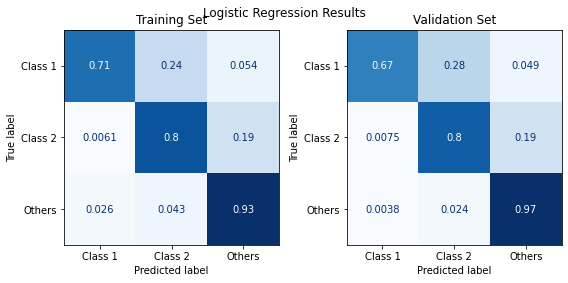

In [27]:
# Confusion Matrix plot
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Logistic Regression Results')
plt.tight_layout()
plt.show()

### SVM

In [5]:
%%time

# Specifying svc
svc = SVC()

# Hyperparameters tested over initially
param_grid = [{'kernel':['rbf','sigmoid','linear','poly'], 'gamma':['auto','scale'], 'C':np.arange(0.1,1.,0.1)}]

# Final hyperparameters
# 75/25
# param_grid = [{'kernel':['rbf',],
#                'gamma':['auto'],
#                'C': [0.9]}]
# 300s
# param_grid = [{'C': [0.8], 'gamma': ['auto'], 'kernel': ['linear']}]
# CM21
# param_grid = [{'C': [0.9], 'gamma': ['auto'], 'kernel': ['rbf']}]

# Define the grid
grid = GridSearchCV(svc,param_grid=param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

CPU times: user 1min 40s, sys: 315 ms, total: 1min 41s
Wall time: 1min 48s


In [6]:
grid.best_params_

{'C': 0.9, 'gamma': 'auto', 'kernel': 'rbf'}

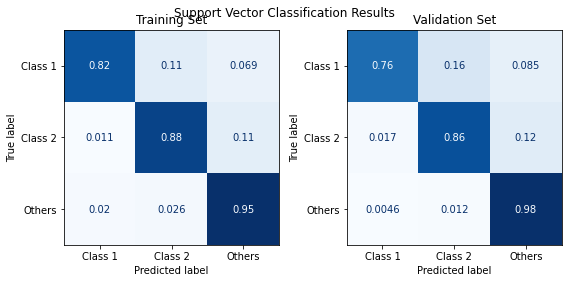

In [7]:
# Confusion Matrix plot
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Support Vector Classification Results')
plt.tight_layout()
plt.show()

### SVM/LR Stacking Ensemble
No GridSearch, uses best pars as defined previously. Adding multiple SVC's does not improve results. **Breanna come back and do new GridSearch!!**

In [12]:
%%time

# Specify Gradient Boost
# 75/25
estimators = [('svc', SVC(kernel='rbf',gamma='auto',C=0.9,random_state=42))]
# logregpars = {penalty = 'l1', max_iter = 500, solver ='saga', tol =0.0001}
# 300s
# estimators = [('svc', SVC('C'=0.8, 'gamma'='auto', 'kernel'='linear'))]
# logregpars = {max_iter=300, penalty='l1', solver='saga', tol=0.0016}
# CM21 
# estimators = [('svc', SVC('C'=0.9, 'gamma'='auto', 'kernel'='rbf'))]
# logregpars = {max_iter=600, penalty='l1', solver='saga','tol': 0.0001}



stacl = StackingClassifier(estimators=estimators,
                           final_estimator=LogisticRegression(penalty = 'l1', max_iter = 500, solver ='saga', tol =0.0001))

# run the data through the grid to find optimal results
stacl.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = stacl.predict(inp_tr)
pred_va = stacl.predict(inp_va)

SyntaxError: ignored

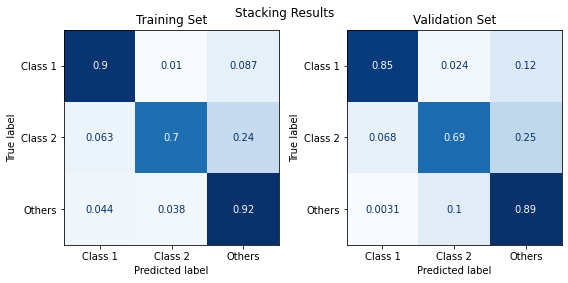

In [19]:
# Confusion Matrix plot
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Stacking Results')
plt.tight_layout()
plt.show()

### Gradient Boosting

In [8]:
%%time

# Specify Gradient Boost
boostcl = GradientBoostingClassifier()

# Hyperparameters tested over initially
param_grid = [{'n_estimators': np.arange(50,250,50),'subsample':[0.5,1.0],
              'criterion':['friedman_mse'],'n_iter_no_change':[5],'warm_start':[True,False],
              'max_depth':np.arange(1,11,2),'max_features': ['sqrt','log2']}]

# Final hyperparameters
# 75/25
# param_grid = [{'criterion': ['friedman_mse'],
#                 'max_depth': [9],
#                 'max_features': ['log2'],
#                 'n_estimators': [50],
#                 'n_iter_no_change': [5],
#                 'subsample': [1.0],
#                 'warm_start': [True]}]
# 300s
# GradientBoostingClassifier(max_depth=7, max_features='log2', n_iter_no_change=5)
#, didn't specify warm start, subsample, or n_estimators, assume same as prev.


# Define the grid
grid = GridSearchCV(boostcl, param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

KeyboardInterrupt: ignored

In [ ]:
grid.best_params_

In [ ]:
# Confusion Matrix plot
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Gradient Boosting Results')
plt.tight_layout()
plt.show()

### XGBoost

In [ ]:
# Specify XGBoost
xgbcl = xgb.XGBClassifier()

# Hyperparameters tested over initially
param_grid = [{'subsample':[0.5,1.0],'max_depth':np.arange(1,11,2),'sampling_method':['uniform']}]

# Final hyperparameters
# 75/25
# param_grid = [{'max_depth': [9], 'sampling_method': ['uniform'], 'subsample': [0.5]}]
# 300s
# XGBClassifier(max_depth=7, objective='multi:softprob',
              # sampling_method='uniform', subsample=0.5)

# Define the grid
grid = GridSearchCV(xgbcl, param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

In [ ]:
grid.best_params_

In [ ]:
# Confusion Matrix plot
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('XGBoost Results')
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
# Specify RF
rfcl = RandomForestClassifier()

# Hyperparameters tested over initially
param_grid = [{'class_weight': ['balanced_subsample','balanced'], 'n_estimators': np.arange(50,250,50),
        'criterion': ['gini', 'entropy'], 'max_features': ['sqrt','log2'], 'oob_score':[True,False]}]

# Final hyperparameters
# 75/25
# param_grid = [{'class_weight': ['balanced_subsample'],
#               'criterion': ['entropy'],
#               'max_features': ['log2'],
#               'n_estimators': [150],
#               'oob_score': [False]}]
# 300s
# RandomForestClassifier(class_weight='balanced', criterion='entropy',
                      #  max_features='log2', n_estimators=50)

# Define the grid
grid = GridSearchCV(rfcl,param_grid=param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

In [ ]:
grid.best_params_

In [ ]:
# Confusion Matrix plot
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Random Forest Results')
plt.tight_layout()
plt.show()

## Neural Network

## Importing

In [ ]:
# library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

# custom script inputs
from NN_Defs import get_n_params, train, validate, BaseMLP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on : {device}')

Running on : cpu


## Scaling, Conversions to Tensors, and DataLoader Creation

In [ ]:
# concatenate the labels onto the inputs for both training and validation
inp_tr = torch.tensor(inp_tr)
tar_tr = torch.tensor(tar_tr)
inp_va = torch.tensor(inp_va)
tar_va = torch.tensor(tar_va)
inp_te = torch.tensor(inp_te)
tar_te = torch.tensor(tar_te)

train_data = data_utils.TensorDataset(inp_tr, tar_tr)
val_data = data_utils.TensorDataset(inp_va, tar_va)
test_data = data_utils.TensorDataset(inp_te, tar_te)

# constructing data loaders for nn
train_loader = torch.utils.data.DataLoader(train_data, batch_size=25, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=25, shuffle=True)

> Todo: Justify the use of batch size here.

## Create Network Instance and Set Hyperparameters

In [ ]:
# create nn instance
BaseNN = BaseMLP(8, 20, 3)

# setting hyperparameters for SGD optimizer
learning_rate = 4e-3
momentum = 0.6

# setting optimizer
optimizer = optim.SGD(BaseNN.parameters(), lr=learning_rate, momentum=momentum)

# setting scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1,threshold=1e-4, cooldown=50, min_lr=1e-6, verbose=True)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,8000], gamma=0.1, verbose=False)

In [ ]:
%%time

# set amounts of epochs
epochs = 20000

# initialize capture variables
train_loss_all = []
val_loss_all = []

for epoch in range(0, epochs):
    train_loss, train_predictions, train_truth_values = train(epoch, BaseNN, optimizer, train_loader, device)
    val_loss, val_accuracy, val_predictions, val_truth_values = validate(BaseNN, val_loader, device)

    # store loss in an array to plot
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)

    #scheduler.step()

    # print outs
    if epoch % 250 == 0:
        print(f'Train Epoch: {epoch} ----- Train Loss: {train_loss.item():.6f}')
        print(f'Validation Loss: {val_loss:.4f}')
        #print(scheduler.get_last_lr())

Train Epoch: 0 ----- Train Loss: 0.720514
Validation Loss: 0.7380
Train Epoch: 250 ----- Train Loss: 0.710350
Validation Loss: 0.7308
Train Epoch: 500 ----- Train Loss: 0.702805
Validation Loss: 0.7226
Train Epoch: 750 ----- Train Loss: 0.696522
Validation Loss: 0.7127
Train Epoch: 1000 ----- Train Loss: 0.691169
Validation Loss: 0.7007
Train Epoch: 1250 ----- Train Loss: 0.687315
Validation Loss: 0.6912
Train Epoch: 1500 ----- Train Loss: 0.684106
Validation Loss: 0.6837
Train Epoch: 1750 ----- Train Loss: 0.681362
Validation Loss: 0.6767
Train Epoch: 2000 ----- Train Loss: 0.678750
Validation Loss: 0.6689
Train Epoch: 2250 ----- Train Loss: 0.676298
Validation Loss: 0.6603
Train Epoch: 2500 ----- Train Loss: 0.673829
Validation Loss: 0.6503
Train Epoch: 2750 ----- Train Loss: 0.671040
Validation Loss: 0.6426
Train Epoch: 3000 ----- Train Loss: 0.668334
Validation Loss: 0.6373
Train Epoch: 3250 ----- Train Loss: 0.665877
Validation Loss: 0.6324
Train Epoch: 3500 ----- Train Loss: 0.66

## Visualizing Results

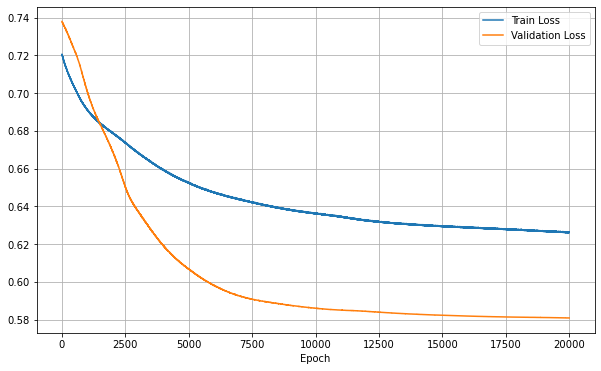

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_all, label='Train Loss')
ax.plot(val_loss_all, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.grid()
plt.show()

## Testing - Predictions of classes

In [ ]:
test_loss, test_accuracy, test_predictions, test_truth_values = validate(BaseNN, test_loader, device)

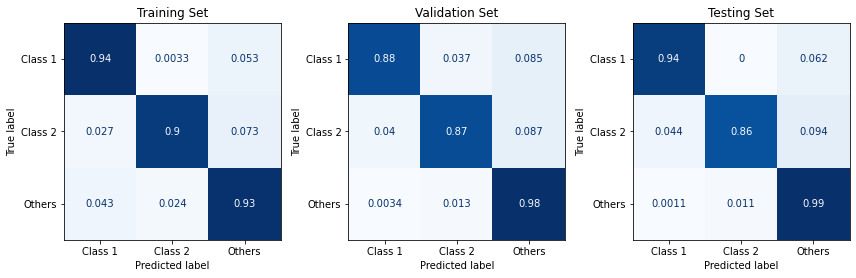

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,20))
ConfusionMatrixDisplay.from_predictions(train_truth_values, train_predictions, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(val_truth_values, val_predictions, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(test_truth_values, test_predictions, ax = ax[2], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
ax[2].set_title('Testing Set')
plt.tight_layout()
plt.show()